In [6]:
import os, sys, pdb, pickle, fnmatch
from collections import OrderedDict

import numpy as np
import scipy as sp
from scipy.signal import savgol_filter

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams

from lr.experiments import ConfigNN

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype']  = 42
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
#rcParams['text.usetex'] = True #Let TeX do the typsetting
#rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
#rcParams['font.family'] = 'sans-serif' # ... for regular text
#rcParams['font.sans-serif'] = 'Helvetica, Avant Garde, Computer Modern Sans serif' # Choose a nice font here

out_dir = './output'

## Experiment Loading Utils

In [81]:
def get_experiments(experiments, v=False):
    experiments = [fn[:-7] for fn in os.listdir(out_dir) if
            np.any([fnmatch.fnmatch(fn[:-7], exp) for exp in experiments])]
    if v: print('Experiments:', experiments)
    return experiments

def load_meta_conf(exp):
    with open(os.path.join(out_dir, exp + '-meta.p'), 'rb') as f:
        meta = pickle.load(f)
    conf = ConfigNN()
    conf.des(meta['Config'])
    acces = []
    updmhs = []
    for ep_t in meta['Train']:
        acces.append(ep_t['TrAccHist'])
        updmhs.append(ep_t['UpdateMaxHist'])
    acces = np.concatenate(acces)
    updmhs = np.concatenate(updmhs)
    useful = {
        'MUpL':updmhs,
        'AccL':acces,
        'AccE':np.mean(acces[-500:]),
    }
    return conf, meta, useful

def get_heat_im(experiments, f):
    experiments = get_experiments(experiments)
    heat = []
    for exp in experiments:
        res = f(exp)
        if res: heat.append(res)
    heat = np.array(heat)
    if heat.size == 0: heat = np.array([[0,0,0]])
    xs = np.sort(np.unique(heat[:,0]))
    ys = np.sort(np.unique(heat[:,1]))
    im = np.zeros((len(xs), len(ys)))
    for el in heat:
        im[np.searchsorted(xs, el[0]), np.searchsorted(ys, el[1])] = el[2]
    return xs, ys, im

## Hyperparameter Selection

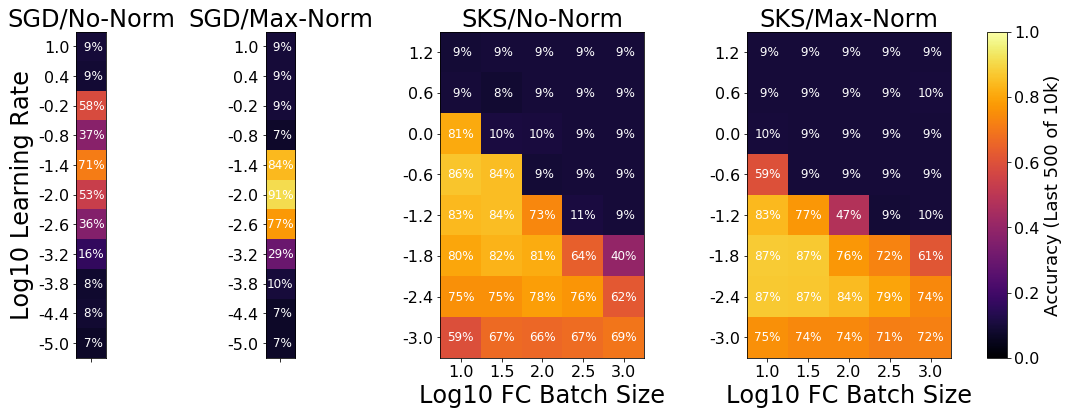

In [84]:
def heat_el_sgd(exp):
    conf, meta, useful = load_meta_conf(exp)
    return [ 0, conf.upd2[1]['lr'], useful['AccE'] ]

def heat_el_sks(exp):
    conf, meta, useful = load_meta_conf(exp)
    return [ conf.upd2[1]['pseudo_batch'], conf.upd2[1]['lr'], useful['AccE'] ]

cmap = 'inferno'
label_kwargs = {'color':'w', 'size':12}

fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(18, 6), ncols=4, gridspec_kw={'width_ratios': [1, 1, 2, 2]})
xs, ys, im = get_heat_im(['lrt-001*'], heat_el_sgd)
ax1.imshow(im.T, origin='lower', cmap=cmap, vmin=0, vmax=1)
ax1.set_xticks(range(len(xs)))
ax1.set_xticklabels([])
ax1.set_yticks(range(len(ys)))
ax1.set_yticklabels(['%.1f'%np.log10(y) for y in ys])
for (i,j),label in np.ndenumerate(im):
    ax1.text(i, j, '%2d%%'%(100*label), ha='center', va='center', **label_kwargs)
ax1.set_ylabel('Log10 Learning Rate', fontsize=24)
ax1.set_title('SGD/No-Norm', fontsize=24)

xs, ys, im = get_heat_im(['lrt-005*'], heat_el_sgd)
ax2.imshow(im.T, origin='lower', cmap=cmap, vmin=0, vmax=1)
ax2.set_xticks(range(len(xs)))
ax2.set_xticklabels([])
ax2.set_yticks(range(len(ys)))
ax2.set_yticklabels(['%.1f'%np.log10(y) for y in ys])
for (i,j),label in np.ndenumerate(im):
    ax2.text(i, j, '%2d%%'%(100*label), ha='center', va='center', **label_kwargs)
ax2.set_title('SGD/Max-Norm', fontsize=24)

xs, ys, im = get_heat_im(['lrt-002*'], heat_el_sks)
ax3.imshow(im.T, origin='lower', cmap=cmap, vmin=0, vmax=1)
ax3.set_xticks(range(len(xs)))
ax3.set_xticklabels(['%.1f'%np.log10(x) for x in xs])
ax3.set_yticks(range(len(ys)))
ax3.set_yticklabels(['%.1f'%np.log10(y) for y in ys])
for (i,j),label in np.ndenumerate(im):
    ax3.text(i, j, '%2d%%'%(100*label), ha='center', va='center', **label_kwargs)
ax3.set_xlabel('Log10 FC Batch Size', fontsize=24)
ax3.set_title('SKS/No-Norm', fontsize=24)

xs, ys, im = get_heat_im(['lrt-006*'], heat_el_sks)
img = ax4.imshow(im.T, origin='lower', cmap=cmap, vmin=0, vmax=1)
ax4.set_xticks(range(len(xs)))
ax4.set_xticklabels(['%.1f'%np.log10(x) for x in xs])
ax4.set_yticks(range(len(ys)))
ax4.set_yticklabels(['%.1f'%np.log10(y) for y in ys])
for (i,j),label in np.ndenumerate(im):
    ax4.text(i, j, '%2d%%'%(100*label), ha='center', va='center', **label_kwargs)
ax4.set_xlabel('Log10 FC Batch Size', fontsize=24)
ax4.set_title('SKS/Max-Norm', fontsize=24)
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='10%', pad=0.5)
cbar = fig.colorbar(img, cax=cax, orientation='vertical')
cbar.set_label('Accuracy (Last 500 of 10k)', fontsize=18)
plt.savefig('figures/heat_hyperparam_selection.pdf', bbox_inches='tight')

plt.show()

## Rank and Bitwidth

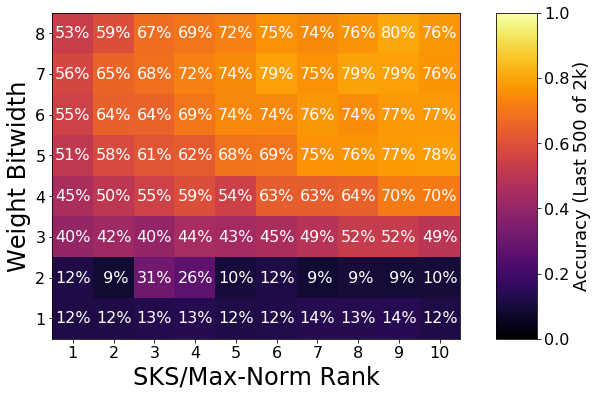

In [29]:
def heat_el_rank_bw(exp):
    conf, meta, useful = load_meta_conf(exp)
    return [ conf.upd2[1]['rank'], abs(conf.qbits['w']), useful['AccE'] ]

cmap = 'inferno'
label_kwargs = {'color':'w', 'size':16}

fig, (ax2) = plt.subplots(figsize=(10, 6), ncols=1, gridspec_kw={'width_ratios': [1]})

xs, ys, im = get_heat_im(['lrt-015*'], heat_el_rank_bw)
img = ax2.imshow(im.T, origin='lower', cmap=cmap, vmin=0, vmax=1, aspect=1.0)
ax2.set_xticks(range(len(xs)))
ax2.set_xticklabels(['%d'%x for x in xs])
ax2.set_yticks(range(len(ys)))
ax2.set_yticklabels(['%d'%y for y in ys])
for (i,j),label in np.ndenumerate(im):
    ax2.text(i, j, '%2d%%'%(100*label), ha='center', va='center', **label_kwargs)
ax2.set_xlabel('SKS/Max-Norm Rank', fontsize=24)
ax2.set_ylabel('Weight Bitwidth', fontsize=24)
#ax2.set_title('SKS/Max-Norm', fontsize=24)

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.5)
cbar = fig.colorbar(img, cax=cax, orientation='vertical')
cbar.set_label('Accuracy (Last 500 of 2k)', fontsize=18)
plt.savefig('figures/heat_rank_bw_mn.pdf', bbox_inches='tight')

plt.show()

## Main Experiments

In [91]:
def unbiased_ema(xs, eta=0.999):
    xema = []
    cur = 0
    for i, x in enumerate(xs):
        cur = eta * cur + (1 - eta) * x
        xema.append(cur / (1 - eta**(i+1)))
    return np.array(xema)

def plot_train(fname, title, exp_base, exps):
    fig, (ax1, ax2) = plt.subplots(figsize=(14,10), nrows=2, gridspec_kw={'height_ratios': [1, 0.5]})
    for exp_label, exp_id in exps.items():
        exp = get_experiments([exp_base + exp_id + '*'])[0]
        conf, meta, useful = load_meta_conf(exp)
        print(meta['Name'], meta['Description'])
        xs = np.arange(len(useful['AccL']))
        ys = unbiased_ema(useful['AccL'], 0.999)
        ax1.plot(xs+1, ys, label=exp_label, linewidth=2)
        ax2.plot(xs+1, useful['MUpL']+1, label=exp_label, linewidth=2)
    
    ax1.set_xscale('log')
    ax1.set_ylabel('Accuracy', fontsize=24)
    ax1.grid(linestyle='--', linewidth=2)
    ax1.tick_params(axis='both', which='major', labelsize=20)
    ax1.legend(loc='lower left', prop={'size': 20})
    
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel('Sample', fontsize=24)
    ax2.set_ylabel('Max # Writes', fontsize=24)
    ax2.grid(linestyle='--', linewidth=2)
    ax2.tick_params(axis='both', which='major', labelsize=20)
    
    plt.tight_layout()
    plt.savefig('figures/plot_%s.pdf'%fname, bbox_inches='tight')
    plt.show()

lrt-020d lrt-020a with inference only.
lrt-020f lrt-020a with no weight training (smaller LR).
lrt-020g lrt-020a with standard weight training (smaller LR).
lrt-020h lrt-020a (smaller LR).
lrt-020e lrt-020a with post-norming.


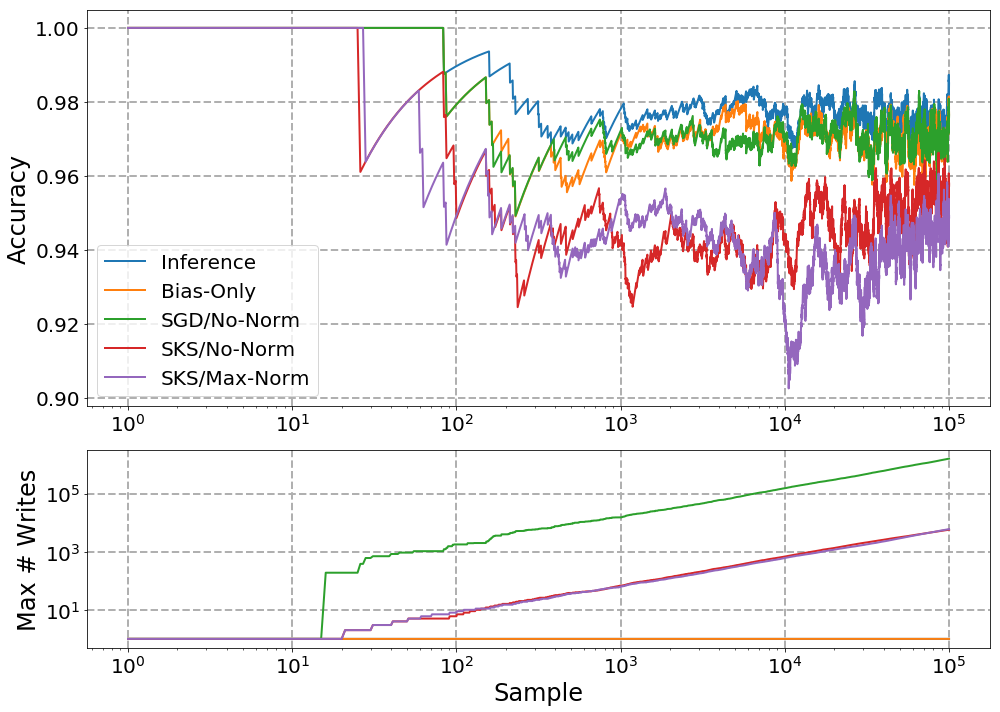

lrt-021d lrt-021a with inference only.
lrt-021f lrt-021a with no weight training (smaller LR).
lrt-021g lrt-021a with standard weight training (smaller LR).
lrt-021h lrt-021a (smaller LR).
lrt-021e lrt-021a with post-norming.


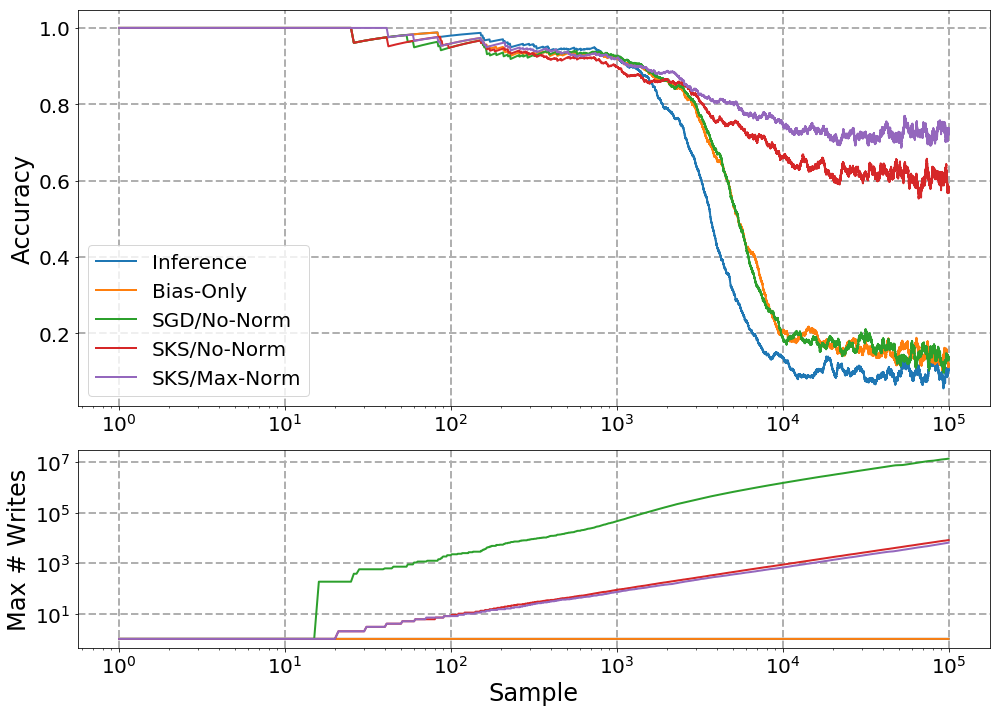

lrt-022d lrt-022a with inference only.
lrt-022f lrt-022a with no weight training (smaller LR).
lrt-022g lrt-022a with standard weight training (smaller LR).
lrt-022h lrt-022a (smaller LR).
lrt-022e lrt-022a with post-norming.


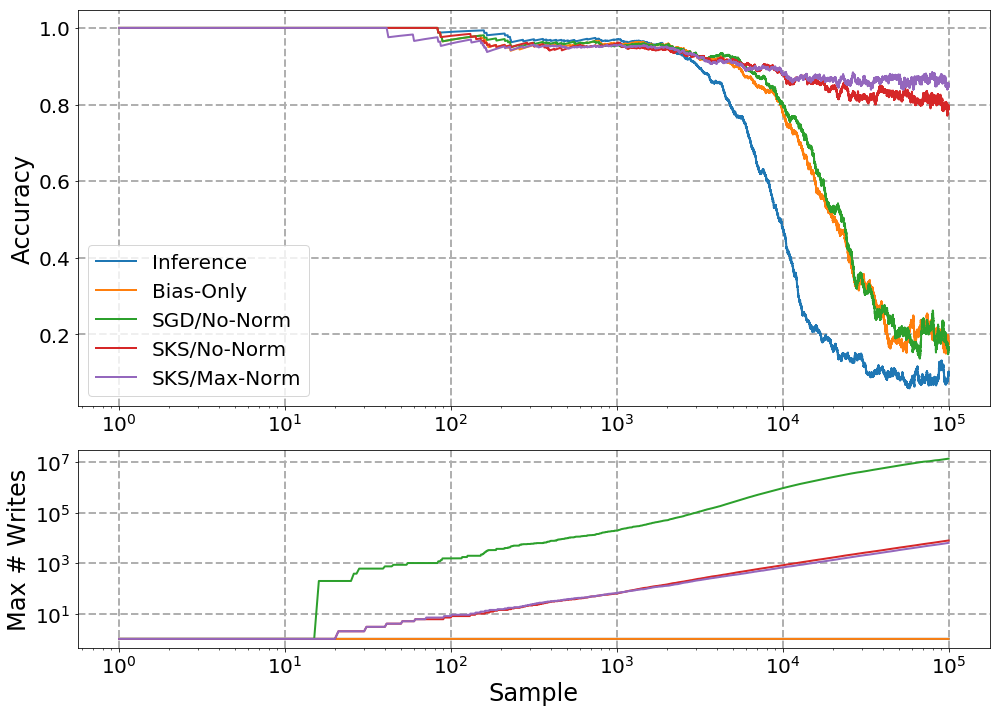

In [92]:
#mapping = {'Inference':'d', 'Bias-Only':'f', 'SGD/No-Norm':'g', 'SKS/No-Norm':'h', 'SKS/Max-Norm':'e'} # Old mapping
mapping = {'Inference':'a', 'Bias-Only':'b', 'SGD/No-Norm':'c', 'SKS/No-Norm':'d', 'SKS/Max-Norm':'e'} # New mapping
plot_train('base_dataset', 'No Non-Idealities', 'lrt-020', mapping)
plot_train('analog_drift', 'Analog (Gaussian) Weight Drift', 'lrt-021', mapping)
plot_train('digital_drift', 'Digital (Bit-Flip) Weight Drift', 'lrt-022', mapping)

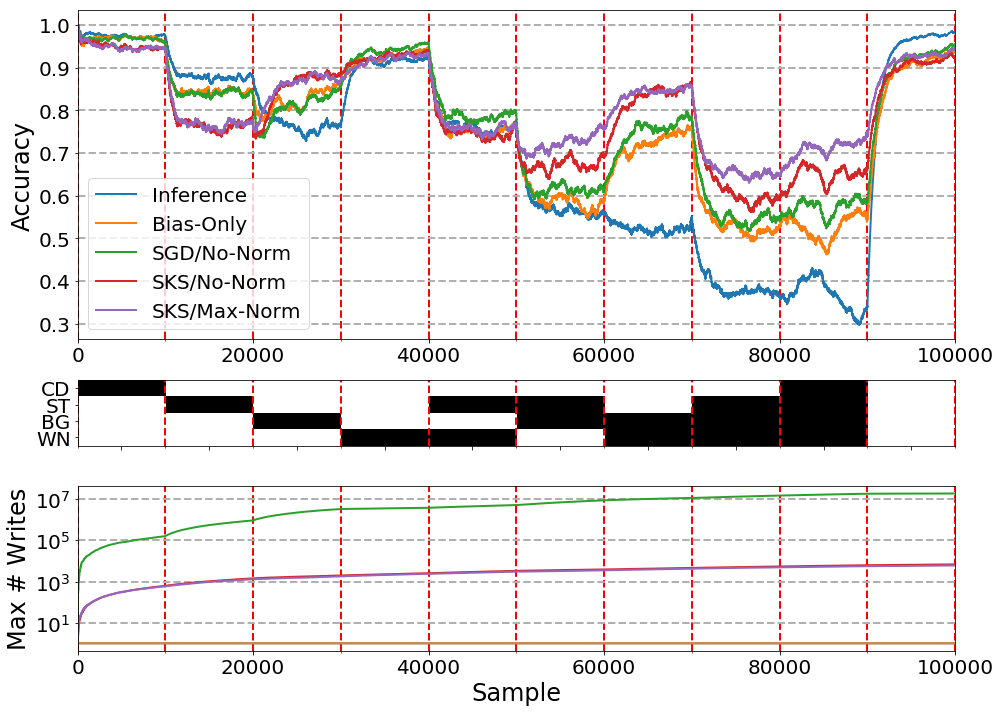

In [95]:
fname = 'distribution_shift'
title = 'Dataset Distribution Shifts'
exp_base = 'lrt-023'
exps = mapping

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,10), nrows=3, gridspec_kw={'height_ratios': [1, 0.2, 0.5]})
for exp_label, exp_id in exps.items():
    exp = get_experiments([exp_base + exp_id + '*'])[0]
    conf, meta, useful = load_meta_conf(exp)
    xs = np.arange(len(useful['AccL']))
    ys = unbiased_ema(useful['AccL'], 0.999)
    ax1.plot(xs+1, ys, label=exp_label, linewidth=2)
    ax3.plot(xs+1, useful['MUpL']+1, label=exp_label, linewidth=2)

ax1.margins(x=0)
ax1.set_ylabel('Accuracy', fontsize=24)
ax1.set_xticks(range(0,101000,10000), minor='True')
ax1.grid(which='major', linestyle='--', linewidth=2)
ax1.grid(which='minor', color='r', linestyle='--', linewidth=2)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax1.legend(loc='lower left', prop={'size': 20})

ax3.set_yscale('log')
ax3.margins(x=0)
ax3.set_xlabel('Sample', fontsize=24)
ax3.set_ylabel('Max # Writes', fontsize=24)
ax3.set_xticks(range(0,101000,10000), minor='True')
ax3.grid(which='major', linestyle='--', linewidth=2)
ax3.grid(which='minor', color='r', linestyle='--', linewidth=2)
ax3.tick_params(axis='both', which='major', labelsize=20)

im = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1], [0,1,0,1], [0,1,1,0], [0,0,1,1], [0,1,1,1], [1,1,1,1], [0,0,0,0]])
ax2.imshow(im.T, cmap='binary', aspect='auto')
ax2.set_xticks(range(10))
ax2.set_xticklabels([])
ax2.set_yticks(range(4))
ax2.set_yticklabels(['CD', 'ST', 'BG', 'WN'])
ax2.set_xticks(np.arange(-.5, 10, 1), minor=True)
ax2.grid(which='minor', color='r', linestyle='--', linewidth=2)
ax2.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.savefig('figures/plot_%s.pdf'%fname, bbox_inches='tight')
plt.show()

## Ablations

In [48]:
def list_train(experiments):
    experiments = get_experiments(experiments)
    aexp = {}
    for exp in experiments:
        conf, meta, useful = load_meta_conf(exp)
        name = meta['Name'][:8]
        if name not in aexp: aexp[name] = []
        aexp[name].append((useful['AccE'], conf))
        aexp[name].sort(key=lambda x: x[0])
    aexp = list(aexp.items())
    aexp.sort(key=lambda x: sum([y[0] for y in x[1]]))
    for name, accs in aexp:
        acc = np.mean([y[0] for y in accs])
        std = np.std([y[0] for y in accs], ddof=1)
        desc = accs[0][1].description
        print('%%%.1f\%% \pm %.1f\%%: %s - %s'%(100*acc, 100*std, name, desc))

In [49]:
list_train(['lrt-011*'])

%82.4\% \pm 1.2\%: lrt-011b - lrt-000 with conv_zv True and fc_zv False.
%82.7\% \pm 1.3\%: lrt-011a - lrt-000 with conv_zv True and fc_zv True.
%83.6\% \pm 2.5\%: lrt-011d - lrt-000 with conv_zv False and fc_zv False.
%84.6\% \pm 2.0\%: lrt-011c - lrt-000 with conv_zv False and fc_zv True.


In [50]:
list_train(['lrt-017*'])

%77.7\% \pm 1.5\%: lrt-017c - lrt-000 with conv_zv False and fc_zv True (no-norm).
%79.7\% \pm 1.1\%: lrt-017a - lrt-000 with conv_zv True and fc_zv True (no-norm).
%81.0\% \pm 0.9\%: lrt-017d - lrt-000 with conv_zv False and fc_zv False (no-norm).
%83.0\% \pm 0.9\%: lrt-017b - lrt-000 with conv_zv True and fc_zv False (no-norm).


In [51]:
list_train(['lrt-012*'])

%68.6\% \pm 1.4\%: lrt-012c - lrt-000 with train_W False.
%81.8\% \pm 1.3\%: lrt-012a - lrt-000 with use_bn False.
%83.0\% \pm 1.4\%: lrt-012b - lrt-000 with train_b False.


In [52]:
list_train(['lrt-013*'])

%81.4\% \pm 1.8\%: lrt-013d - lrt-000 with conv mods {'min_density': 0.1}; fc mods {'min_density': 0.1}.
%82.4\% \pm 1.0\%: lrt-013g - lrt-000 with conv mods {'norm_uv': None}; fc mods {'norm_uv': None}.
%83.0\% \pm 1.1\%: lrt-013a - lrt-000 with conv mods {}; fc mods {}.
%83.0\% \pm 0.3\%: lrt-013f - lrt-000 with conv mods {'discount': 0.9}; fc mods {'discount': 0.9}.
%83.2\% \pm 1.5\%: lrt-013e - lrt-000 with conv mods {'min_density': 0}; fc mods {'min_density': 0}.
%84.2\% \pm 1.4\%: lrt-013c - lrt-000 with conv mods {'kappa_th': 100000000.0}; fc mods {'kappa_th': 100000000.0}.
%84.3\% \pm 1.9\%: lrt-013b - lrt-000 with conv mods {'kappa_th': 10}; fc mods {'kappa_th': 10}.
